In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
%%capture
!unzip chest-xray-pneumonia.zip

# Importing Libraries

In [9]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import recall_score,precision_score,f1_score,accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV


### Data Directories

In [10]:
train_directory = "/content/chest_xray/train"
test_directory = "/content/chest_xray/test"
val_directory = "//content/chest_xray/val"

In [11]:
print(os.listdir(train_directory))
print(os.listdir(test_directory))
print(os.listdir(val_directory))

['PNEUMONIA', 'NORMAL']
['PNEUMONIA', 'NORMAL']
['PNEUMONIA', 'NORMAL']


In [12]:
os.listdir(val_directory)[0]

'PNEUMONIA'

In [13]:
labels = ["PNEUMONIA","NORMAL"]
labels

['PNEUMONIA', 'NORMAL']

In [14]:
def accessingfolder(directory):
    normal = os.path.join(directory,"NORMAL")
    pneumonia = os.path.join(directory,"PNEUMONIA")

    return normal,pneumonia

### Overview Of DATA

In [15]:
# Checking number of Sample

# for test_directory

test_normal , test_pneu = accessingfolder(test_directory)
print("Number of Normal in Test: ", len(os.listdir(test_normal)))
print("Number of Pneumonia in Test: ", len(os.listdir(test_pneu)))


# for train_directory
train_normal , train_pneu = accessingfolder(train_directory)
print("Number of Normal in Train: ", len(os.listdir(train_normal)))
print("Number of Pneumonia in Train: ", len(os.listdir(train_pneu)))

# for train_directory
val_normal , val_pneu = accessingfolder(val_directory)
print("Number of Normal in Val: ", len(os.listdir(val_normal)))
print("Number of Pneumonia in Val: ", len(os.listdir(val_pneu)))

Number of Normal in Test:  234
Number of Pneumonia in Test:  390
Number of Normal in Train:  1341
Number of Pneumonia in Train:  3875
Number of Normal in Val:  8
Number of Pneumonia in Val:  8


In [16]:
os.listdir(val_normal)[0]

'NORMAL2-IM-1430-0001.jpeg'

In [17]:
sample_normal = os.listdir(train_normal)[0]
sample_pneu=os.listdir(train_pneu)[0]
print(sample_normal)

IM-0551-0001-0002.jpeg


### **Creating a Function to print image**

In [18]:
def printimage(df,sample):
    image =  os.path.join(df,sample) #chest_xray/train/normal/ + xyz.jpeg -> accessing Image
    img = cv2.imread(image)
    print("Shape of Image: ",img.shape)
    return plt.imshow(img)

Shape of Image:  (1341, 1624, 3)


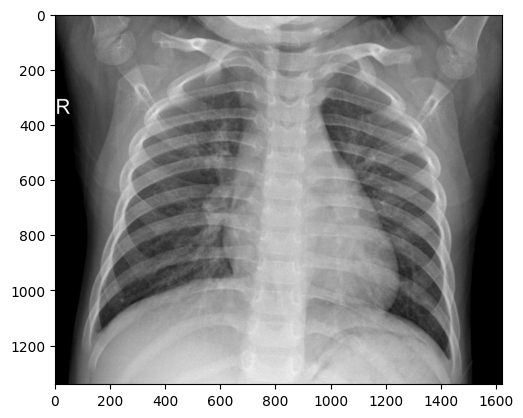

In [19]:
printimage(train_normal,sample_normal)

Shape of Image:  (608, 800, 3)


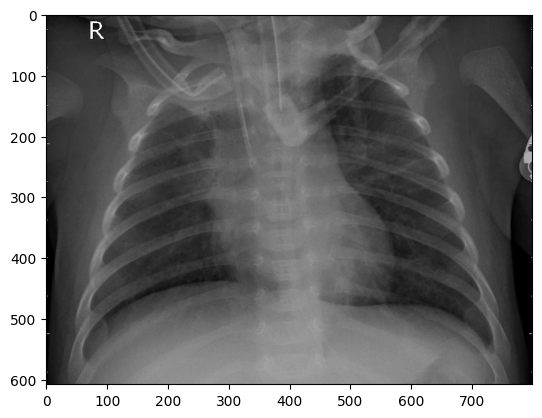

In [20]:
printimage(train_pneu,sample_pneu)

**SIZE OF IMAGES ARE NOT SAME**

# Split Data into Target & Data

### + Resizing the size of each image (128 * 128)

In [21]:
def separation(directory, x, y):

    # iterating over normal and pneumonia (total 2 iteration)
    for i in labels:
        path = os.path.join(directory,i)

        for img in os.listdir(path):
            #read images
            current_image = cv2.imread(os.path.join(path,img))

            if current_image is not None:
                resized_img = cv2.resize(current_image,(128,128))
                x.append(resized_img)
                y.append(labels.index(i))
    return x,y

In [22]:
X  = []
y  = []
X  , y = separation(train_directory, X , y )
X  , y = separation(test_directory, X, y )
X  , y = separation(val_directory, X , y )

In [23]:
type(X),type(y)

(list, list)

We need ndarray not list

In [24]:
# function to convert list into numpy array
def convert_to_array(x,y):
    x = np.array(x)
    y = np.array(y)
    return x,y

In [25]:
X  , y  = convert_to_array(X,y)
print(X.shape)
print(y.shape)

(5856, 128, 128, 3)
(5856,)


Number of samples: 5856

Height of samples: 128 pixels

Width of samples: 128 pixels

Number of color channels: 3

In [26]:
type(X),type(y)

(numpy.ndarray, numpy.ndarray)

# Flattening the data

Unrolling the 3D array into a 2D array, where each row represents a single image

In [27]:
X_flat = X.reshape(X.shape[0],-1)
X_flat.shape,y.shape

((5856, 49152), (5856,))

Now, each row of data_flat represents a single image, with 49152 features

In [28]:
unique_value, counts = np.unique(y,return_counts=True)
unique_value,counts

(array([0, 1]), array([4273, 1583]))

# Splitting the DATA

In [29]:
X_train,X_test,y_train,y_test=train_test_split(X_flat,y,test_size=0.2,random_state=42)

In [30]:
X_test,X_val,y_test,y_val=train_test_split(X_test,y_test,test_size=0.2,random_state=42)

In [31]:
X_train.shape,y_train.shape

((4684, 49152), (4684,))

In [32]:
X_test.shape,y_test.shape

((937, 49152), (937,))

In [33]:
X_val.shape,y_val.shape

((235, 49152), (235,))

In [34]:
y_train[:100]

array([1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0])

# Using SVM

In [ ]:
model = SVC(max_iter=10000,)
model.fit(X_train,y_train)

SVC(max_iter=10000)

In [ ]:

y_pred=model.predict(X_test)

In [ ]:
accuracy=accuracy_score(y_test,y_pred)
print("accuracy:",accuracy*100 ,"%")

In [ ]:
print("f1 score: " , f1_score(y_test,y_pred))

## Confusion Matrics of SVM

In [ ]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred)
cm

In [ ]:
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix')
plt.show()

# Handling IMBALANCED DATA

## Using SMOTE to Balance DATA

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

smt=SMOTE()
X_train_sm, y_train_sm = smt.fit_resample(X_train, y_train)
counter = Counter(y_train_sm)
print('After', counter)

After Counter({1: 3408, 0: 3408})


### PLotting balanced vs imbalanced data

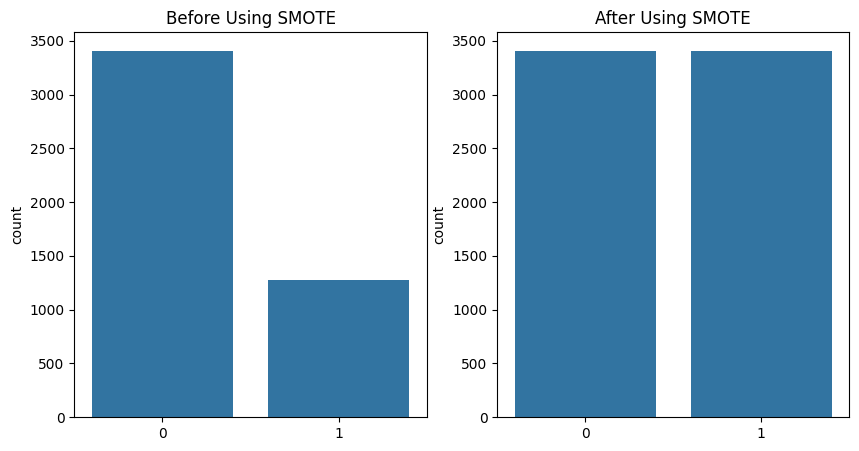

In [ ]:
fig, ax = plt.subplots(1, 2,figsize=(10,5))
sns.countplot(x = y_train,ax=ax[0])
sns.countplot(x = y_train_sm,ax=ax[1])
ax[0].set_title("Before Using SMOTE")
ax[1].set_title("After Using SMOTE")
plt.show()

# Training Model on BALANCED DATA

In [ ]:
model2 = SVC(max_iter=10000,)
model2.fit(X_train_sm,y_train_sm)

SVC(max_iter=10000)

In [ ]:
y_pred2=model2.predict(X_test)
accuracy_model2=accuracy_score(y_test,y_pred2)
print("accuracy:",accuracy_model2*100 ,"%")
print("f1 score:",f1_score(y_test,y_pred2))

accuracy: 95.90443686006826 %
f1 score: 0.9215686274509803


# USING XGBOOST

In [ ]:
%%capture
!pip install xgboost

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
xgb = XGBClassifier()
xgb.fit(X_train,y_train)

xgb_pred = xgb.predict(X_test)
xgb_accuracy=accuracy_score(y_test,xgb_pred)
print("Accuracy :",xgb_accuracy)



print("F1 Score: ",f1_score(y_test,xgb_pred))



Accuracy : 0.947098976109215
F1 Score:  0.8963210702341137


# HyperParameter Tuning For SVC

In [35]:
param_grid = {
    'C': [ 10, 100, 200],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto'],
    'coef0': [0, 1, 10]
}

In [36]:
svc_model = SVC()


In [37]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [38]:
# Perform random search
random_search = RandomizedSearchCV(svc_model, param_grid, cv=5, scoring='accuracy', n_iter=10, random_state=42)


In [39]:
random_search.fit(X_val, y_val)

RandomizedSearchCV(cv=5, estimator=SVC(),
                   param_distributions={'C': [0.1, 1, 10, 100],
                                        'coef0': [0, 1, 10],
                                        'degree': [2, 3, 4],
                                        'gamma': ['scale', 'auto'],
                                        'kernel': ['linear', 'rbf', 'poly']},
                   random_state=42, scoring='accuracy')

In [40]:
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

Best parameters: {'kernel': 'rbf', 'gamma': 'scale', 'degree': 3, 'coef0': 10, 'C': 100}
Best score: 0.9319148936170212


## Training SVC model on the BEST PARAMS

In [41]:
best_params = {'kernel': 'rbf',
               'gamma':'scale',
               'degree': 3,
               'coef0': 10,
               'C': 100 }

hyper_svc = SVC(**best_params)
hyper_svc.fit(X_train, y_train)

SVC(C=100, coef0=10)

In [42]:
hyper_y_pred = hyper_svc.predict(X_test)
accuracy = accuracy_score(y_test, hyper_y_pred)
print("Accuracy on test data:", accuracy)

Accuracy on test data: 0.9637139807897546


In [43]:
f1_score(y_test,hyper_y_pred)


0.9300411522633746